In [0]:
#conect notebook to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import gridspec

import numpy as np
from scipy.misc import imresize
import scipy
import pandas as pd
import random

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import adam, RMSprop, SGD

Using TensorFlow backend.


In [0]:
# create list of brands to download
brands = ['VOLKSWAGEN',  'RENAULT', 'FORD', 'PEUGEOT', 'OPEL', 'MERCEDES', 
          'BMW', 'AUDI', 'FIAT', 'SKODA', 'TOYOTA', 'CITROEN', 'HYUNDAI', 
          'NISSAN', 'DACIA', 'KIA', 'SEAT', 'VOLVO', 'MINI', 'JEEP']

# create list features 
list_feature = ['logo', 'logo jpg', 'logo png', 'logo gif', 'logo wector', 
                'logo image', 'logo hd','logo wallpaper', 'logo emblem', 
                'brand logo', 'grill']

# Modify brands to lowercase leaters
list_brands = []

for brand in brands:
  brand = brand.lower()
  list_brands.append(brand)
  
  
#Create a search words, by appeding to each brand all features 
serch_word = []

for brand in list_brands:
  for feture in list_feature:
    serch_word.append(brand + ' '+ feture)
    
print(serch_word[:5])    

['volkswagen logo', 'volkswagen logo jpg', 'volkswagen logo png', 'volkswagen logo gif', 'volkswagen logo wector']


In [0]:
""" Make directories for brands and move there resized images,
    without invalid files
"""

images_path = '/content/drive/My Drive/logo/'
save_path = '/content/drive/My Drive/logo_folders/'
extension = ('.jpg', '.jpeg', '.png', '.gif')

for brand in list_brands:
  search_path = images_path + '*' + brand + '*'
  save_path_brand = save_path + brand
  print(search_path)
  glob_filenames = glob.glob(search_path)
  output_dir = save_path + brand
  os.mkdir(output_dir)
  i = 0
  for file_path in glob_filenames:
    print(file_path)
    print('###############################################')
    for root, dirs, files in os.walk(file_path):  
      for file in files:
        if file.endswith(extension):
          try:
            print(file_path + '/' + file)
            image_path = file_path + '/' + file
            save_path_brand = save_path + brand + '/' + brand + str(i) + '.jpg'
            img = Image.open(image_path)
            new_img = img.convert('RGB').save(save_path_brand)
            print(save_path_brand)
            i += 1
            gc.collect()
          except OSError:
            pass
          except FileNotFoundError:
              pass

In [0]:
train_path = "/content/drive/My Drive/logo_224_cleaned/train/"
validation_path = "/content/drive/My Drive/logo_224_cleaned/validation/"

In [0]:
#Split walidation images to separate folders

Validation_size = 50

for path, dirs, files in os.walk(train_path): 
  for directory in dirs:
    brand_path = train_path + directory + '/'
    save_path = validation_path + directory + '/'
    print (save_path)
    os.mkdir(save_path)
    for  path, dirs, files in os.walk(brand_path):
      random_files = random.sample(files, Validation_size)
      for file in random_files:
        file_path = brand_path + file
        #print (file_path)
        shutil.move(file_path, save_path)

/content/drive/My Drive/logo_224_cleaned/validation/fiat/
/content/drive/My Drive/logo_224_cleaned/validation/bmw/
/content/drive/My Drive/logo_224_cleaned/validation/hyundai/
/content/drive/My Drive/logo_224_cleaned/validation/audi/
/content/drive/My Drive/logo_224_cleaned/validation/mercedes/
/content/drive/My Drive/logo_224_cleaned/validation/jeep/
/content/drive/My Drive/logo_224_cleaned/validation/citroen/
/content/drive/My Drive/logo_224_cleaned/validation/dacia/
/content/drive/My Drive/logo_224_cleaned/validation/kia/
/content/drive/My Drive/logo_224_cleaned/validation/ford/
/content/drive/My Drive/logo_224_cleaned/validation/seat/
/content/drive/My Drive/logo_224_cleaned/validation/mini/
/content/drive/My Drive/logo_224_cleaned/validation/nissan/
/content/drive/My Drive/logo_224_cleaned/validation/peugeot/
/content/drive/My Drive/logo_224_cleaned/validation/volkswagen/
/content/drive/My Drive/logo_224_cleaned/validation/volvo/
/content/drive/My Drive/logo_224_cleaned/validation

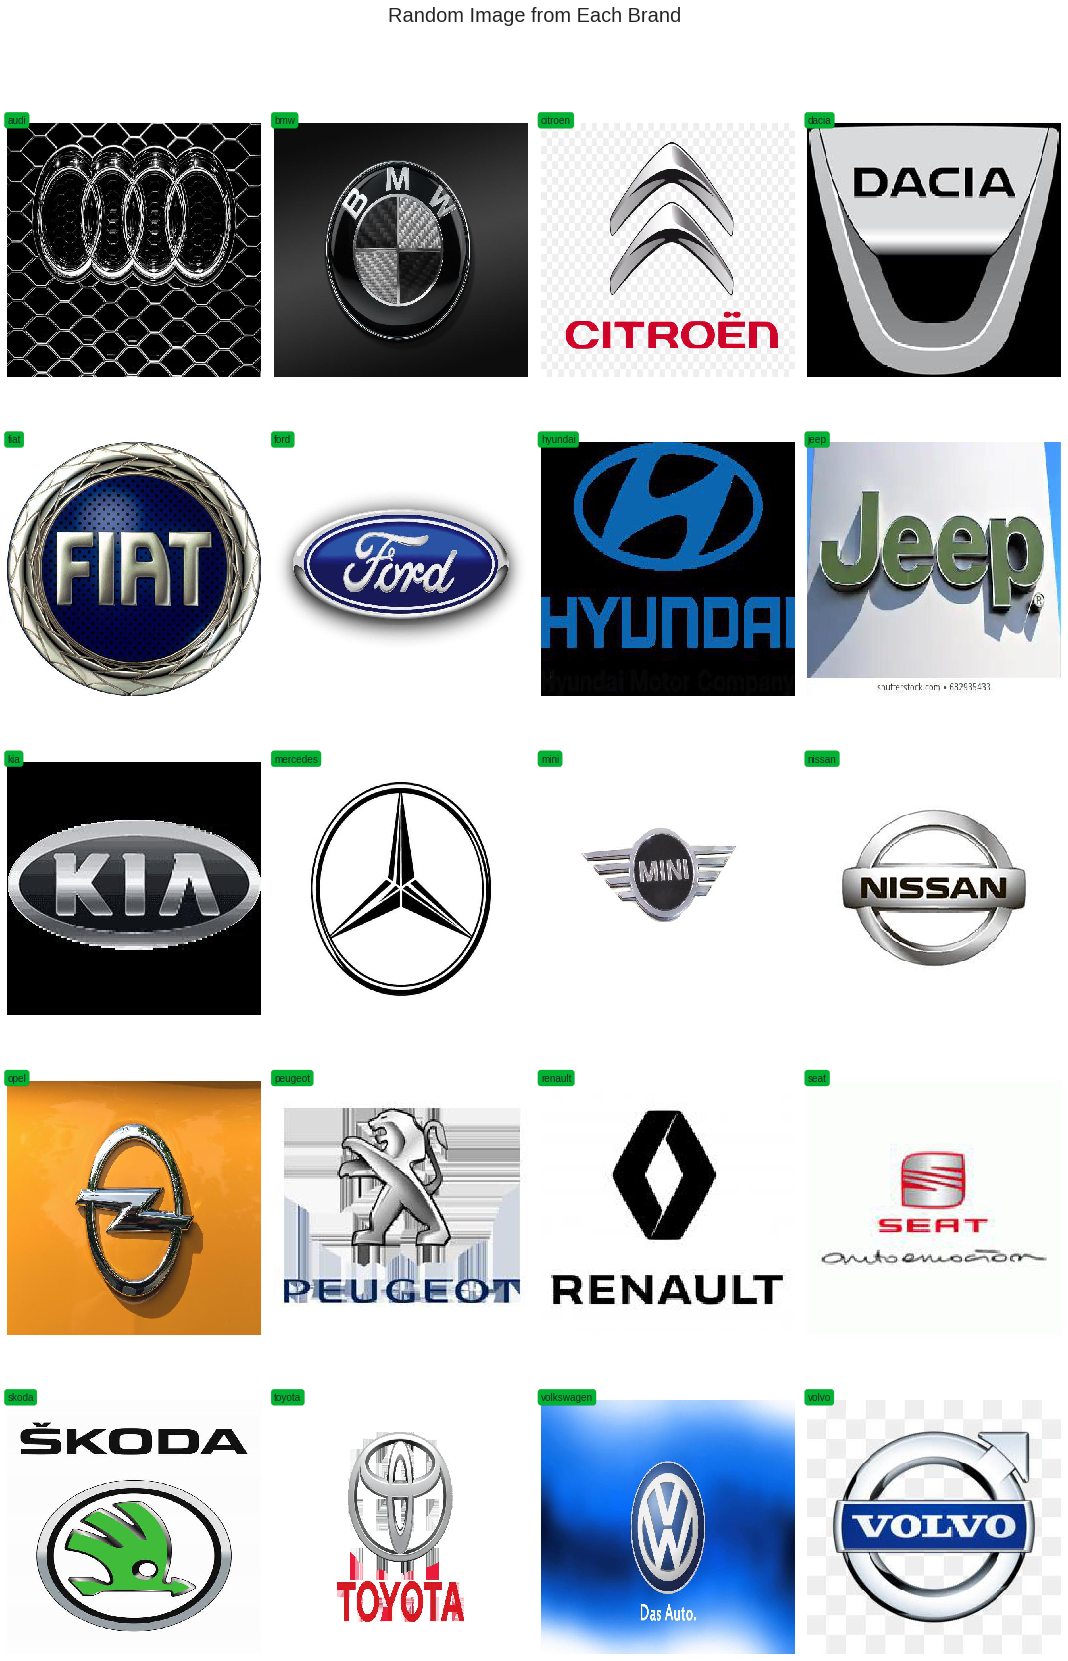

In [0]:
# show random image from each brand

root_dir = train_path
rows = 5
cols = 4
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Brand', fontsize=20)
sorted_dirs = sorted(os.listdir(root_dir))

for i in range(rows):
    for j in range(cols):
        try:
            brand_dir = sorted_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, brand_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, brand_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, brand_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
        
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [0]:
# Assigned brands to classes and classes to brands

class_to_ix = {}
ix_to_class = {}

classes = list_brands
class_to_ix = dict(zip(classes, range(len(classes))))
ix_to_class = dict(zip(range(len(classes)), classes))
class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [0]:
def load_images(root):
  """ Assigned each image to a class
      and make arrays from images
  """
  all_imgs = []
  all_classes = []
  for i, subdir in enumerate(listdir(root)):
    imgs = listdir(join(root, subdir))
    class_ix = class_to_ix[subdir]
    print(i, class_ix, subdir)
    for img_name in imgs:
      img_arr = scipy.misc.imread(join(root, subdir, img_name))
      all_imgs.append(img_arr)
      all_classes.append(class_ix)
  return np.array(all_imgs), np.array(all_classes) 


In [0]:
X_train, y_train = load_images(train_path)
X_val, y_val = load_images(validation_path)


0 8 fiat


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


1 6 bmw
2 12 hyundai
3 7 audi
4 5 mercedes
5 19 jeep
6 11 citroen
7 14 dacia
8 15 kia
9 2 ford
10 16 seat
11 18 mini
12 13 nissan
13 3 peugeot
14 0 volkswagen
15 17 volvo
16 9 skoda
17 4 opel
18 1 renault
19 10 toyota
0 8 fiat
1 6 bmw
2 12 hyundai
3 7 audi
4 5 mercedes
5 19 jeep
6 11 citroen
7 14 dacia
8 15 kia
9 2 ford
10 16 seat
11 18 mini
12 13 nissan
13 3 peugeot
14 0 volkswagen
15 17 volvo
16 9 skoda
17 4 opel
18 1 renault
19 10 toyota


In [0]:
print('Shapes of train and validation data')
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)


Shapes of train and validation data
X_train shape (5421, 224, 224, 3)
y_train shape (5421,)
X_val shape (1000, 224, 224, 3)
y_val shape (1000,)


In [0]:
def show_random_images_of_class(n_class=0):
    """ Show few images from chosee class"""
    print(n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    imgs = np.random.choice((y_train == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_train[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

In [0]:
# change data to categorical
n_classes = len(list_brands)
y_train_cat =to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

In [0]:
# Make a generator for scaling, rotating, filiping images 
train_generator = ImageDataGenerator(rescale=1/255, 
                                     rotation_range=90, 
                                     zoom_range=0.2, 
                                     horizontal_flip=True)
validation_generator =ImageDataGenerator(rescale=1/255)


In [0]:
train_flow = train_generator.flow(X_train, y=y_train_cat,
                                  batch_size=32, )
                                 

validation_flow = validation_generator.flow(X_val, y=y_val_cat,
                                            batch_size=32, )                                                 

In [0]:
from keras.applications import MobileNet
h,w = 224, 224
base_model=MobileNet(weights='imagenet',
                     include_top=False,
                     input_shape=(h, w, 3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
base_model.output_shape[1:]

(1000,)

In [0]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dense(20, activation='sigmoid'))
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 20)                10260     
Total params: 51,916,308
Trainable params: 51,916,308
Non-trainable params: 0
_________________________________________________________________


In [0]:
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(top_model)

transfer_model.layers[0].trainable = False
early_stopping = EarlyStopping(patience=4, monitor='val_loss')
save_file = '/content/drive/My Drive/logo_dataset/model20classes_v4.h5py' 
take_best_model = ModelCheckpoint(save_file, save_best_only=True)
transfer_model.compile(loss="categorical_crossentropy",
              optimizer = 'adam',
              metrics = ['categorical_accuracy'])


transfer_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
sequential_4 (Sequential)    (None, 20)                51916308  
Total params: 55,145,172
Trainable params: 51,916,308
Non-trainable params: 3,228,864
_________________________________________________________________


In [0]:

nb_validation_samples = X_val.shape[0]
nb_train_samples = X_train.shape[0]
transfer_model.fit_generator(generator=train_flow, 
                    samples_per_epoch=nb_train_samples,
                    validation_data=validation_flow,
                    nb_val_samples=nb_validation_samples,
                    epochs=20)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<keras_pre..., validation_data=<keras_pre..., epochs=20, steps_per_epoch=169, validation_steps=1000)`
  


Epoch 1/20
169/169 [==============================] - 5288s 31s/step - loss: 5.8296 - categorical_accuracy: 0.0669 - val_loss: 6.6885 - val_categorical_accuracy: 0.0500
Epoch 2/20
169/169 [==============================] - 4910s 29s/step - loss: 5.8713 - categorical_accuracy: 0.0677 - val_loss: 6.6768 - val_categorical_accuracy: 0.0498
Epoch 3/20
169/169 [==============================] - 4790s 28s/step - loss: 5.9024 - categorical_accuracy: 0.0674 - val_loss: 6.6829 - val_categorical_accuracy: 0.0500
Epoch 4/20
169/169 [==============================] - 4775s 28s/step - loss: 5.9024 - categorical_accuracy: 0.0670 - val_loss: 6.6829 - val_categorical_accuracy: 0.0501
Epoch 5/20
169/169 [==============================] - 4684s 28s/step - loss: 5.8804 - categorical_accuracy: 0.0683 - val_loss: 6.6829 - val_categorical_accuracy: 0.0500
Epoch 6/20
169/169 [==============================] - 4612s 27s/step - loss: 5.8389 - categorical_accuracy: 0.0658 - val_loss: 6.6781 - val_categorical_acc

KeyboardInterrupt: ignored

In [0]:
import os
from PIL import Image
images_path = "/content/drive/My Drive/logo_full_size_cleaned/"
save_path = "/content/drive/My Drive/logo_224_cleaned/train/"
extension = ('.jpg', '.jpeg', '.png', '.gif')

for path, dirs, files in os.walk(images_path): 
  for dire in dirs: 
    brand = dire
    brand_path = images_path + dire + '/'
    save_path_brand = save_path + brand +'/'
    os.mkdir(save_path_brand)
    print(brand_path)
    for path, dirs, files in os.walk(brand_path):
      for file in files:
        try:
          file_path = brand_path + file
          file_save_path = save_path + brand +'/' + file
          img = Image.open(file_path)
          new_img = img.convert('RGB').resize((224,224)).save(file_save_path)
          print(file_path)
          print(file_save_path)
        except FileExistsError:
          pass

In [0]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
albumentations==0.1.12
altair==2.4.1
astor==0.7.1
astropy==3.0.5
atari-py==0.1.7
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.6
autograd==1.2
Babel==2.6.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
bokeh==1.0.4
boto==2.49.0
boto3==1.9.115
botocore==1.12.115
Bottleneck==1.2.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.0
certifi==2019.3.9
cffi==1.12.2
chainer==5.0.0
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.1.3
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.14.6
cvxopt==1.2.3
cvxpy==1.0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.6
cytoolz==0.9.0.1
daft==0.0.4
dask==0.20.2
dataclasses==0.6
datascience==0.10.6
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
distributed==1.25.3
Django==2.1.7
dlib==19.16.0
dm-sonnet==1.23
docopt==0.6.2
docutils==0.14
dopamine-rl==1.0.5
easydict==1.9
ecos